In [1]:
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.features import rasterize

import pandas as pd
import geopandas as geopd

import numpy as np
import numpy.ma as ma

from tqdm.notebook import tqdm

import os
import warnings

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

In [2]:
src_path = "/home/iielse/Documents/DIWA/data/CAMELS-FI catchments/CAMELS-FI_catchments.gpkg"
dst_path = "/home/iielse/Documents/DIWA/data/CAMELS-FI catchments/catchment_attributes.gpkg"


land_cover_paths = {2000: "/home/iielse/Documents/GIS-sync/perusdata/syke/corine/clc2000_fi25m/Clc2000_CAMELS_classification.tif", 
    2006: "/home/iielse/Documents/GIS-sync/perusdata/syke/corine/clc2006_fi25m/Clc2006_CAMELS_classification.tif",
    2012: "/home/iielse/Documents/GIS-sync/perusdata/syke/corine/clc2012_fi20m/Clc2012_CAMELS_classification.tif",
    2018: "/home/iielse/Documents/GIS-sync/perusdata/syke/corine/clc2018_fi20m/Clc2018_CAMELS_classification.tif"
}

lc_classes = {1 : "crop", 2 : "grass", 3 : "shrubs",
              4 : "dwood", 5: "ewood", 6: "urban",
              7:"inwater", 8: "bares", 9: "wetland"
             }
# Getting all the land cover column names
lc_columns = []
for lc_year in land_cover_paths:
    lc_columns.extend([f"{lc_classes[key]}_perc_{lc_year}" for key in lc_classes.keys()])

soil_path = "/home/iielse/Documents/DIWA/data/GTK/maaperä_sliced.gpkg"
soil_classes = {
    "bedrock": [195110, 195111, 195112, 195312],
    "glaciofluvial": [195310],
    "silt": [195410],
    "till": [195210],
    "clay": [195413, 195511, 195618],
    "peat": [19551891, 19551892, 19551822]
    }
soil_columns = [f"{key}_perc" for key in soil_classes]

soil_depth_path = "/home/iielse/Documents/GIS-sync/perusdata/GTK/maapeitepaksuus_1m_epsg3067_tiff_jpg/maapeitepaksuus_1000k.tif"

slope_path = "/media/iielse/T9/gisT7/korkeusmalli_10_m/slope10m.tif"

dem_path = "/media/iielse/T9/gisT7/korkeusmalli_10_m/korkeusmalli_10_m.vrt"

In [3]:
watersheds = geopd.read_file(src_path)
# Deleting sliver polygons
watersheds = watersheds[watersheds.area > 100]
watersheds = watersheds.reset_index(drop=True)

In [4]:
watersheds

,Paikka_Id,area,geometry
0,996,3.079473e+09,"POLYGON ((381210 7007980, 381210 7007970, 3811..."
1,1003,2.158788e+09,"POLYGON ((461570 7052380, 461570 7052370, 4615..."
2,1008,5.763810e+09,"POLYGON ((461570 7052380, 461570 7052370, 4615..."
3,1009,5.966547e+09,"POLYGON ((461570 7052380, 461570 7052370, 4615..."
4,1012,6.883996e+09,"POLYGON ((461570 7052380, 461570 7052370, 4615..."
...,...,...,...
315,961,2.072101e+09,"POLYGON ((589840 7022170, 589840 7022140, 5898..."
316,964,4.485919e+08,"POLYGON ((518500 6957260, 518500 6957250, 5184..."
317,1369,2.014959e+08,"POLYGON ((494629.907 7381100.953, 494629.907 7..."
318,1366,3.985687e+08,"POLYGON ((488999.91 7357010.684, 488999.91 735..."


In [5]:
def add_lc_to_watersheds(subwatersheds, land_cover_path, lc_classes, year):
    """
    Adds land cover classification proportions of a spesific year to subwatersheds.

    Parameters:
    subwatersheds (GeoDataFrame): A GeoDataFrame containing subwatershed geometries and attributes.
    land_cover_path (str): Path to the land cover raster file.
    lc_classes (dict): A dictionary mapping land cover class values to their names.
    year (int): The year of the land cover data.
    bounds (tuple): A tuple containing the bounding box coordinates (minx, miny, maxx, maxy).

    Returns:
    GeoDataFrame: The input GeoDataFrame with additional columns for each land cover class proportion.
    """
    place_id = subwatersheds.at[0, 'Paikka_Id']

    for j, subwatershed in subwatersheds.iterrows():

        subwatershed = geopd.GeoDataFrame(
                dict(zip(list(subwatershed.index), list(subwatershed.values))),
                crs=subwatersheds.crs, geometry='geometry', index=[0])

        minx = subwatershed.bounds.at[0, 'minx']
        miny = subwatershed.bounds.at[0, 'miny']
        maxx = subwatershed.bounds.at[0, 'maxx']
        maxy = subwatershed.bounds.at[0, 'maxy']

        with rasterio.open(land_cover_path) as src:
            profile = src.profile
            values = src.read(
                1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
                boundless=True, fill_value=profile['nodata'])
        
        profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
        profile['width'] = values.shape[1]
        profile['height'] = values.shape[0]
        
        area_mask = rasterize(
                subwatershed['geometry'], (profile['height'], profile['width']),
                dtype=profile['dtype'], transform=profile['transform'], all_touched=True)
        
        area = area_mask.sum()
        
        clipped_values = np.where(area_mask == 1, values, 0)
        for key in lc_classes:
            class_name = lc_classes[key]
            class_values = np.where(clipped_values == key, 1, 0)
        
            class_area = class_values.sum()
    
            # Some subwaterhseds cause minor problems 
            warnings.filterwarnings("error")
            
            try:
                class_portion = class_area / area
    
            except:
                class_portion = 0
                print(f"{class_name}_perc was set to zero for watershed {place_id}, subwatershed {j} because {class_area} or {area} were invalid features")
            warnings.filterwarnings("default")
            
            # multiplying by 100 gives percentages
            subwatersheds.at[j, f"{class_name}_perc_{year}"] = class_portion * 100

    return subwatersheds

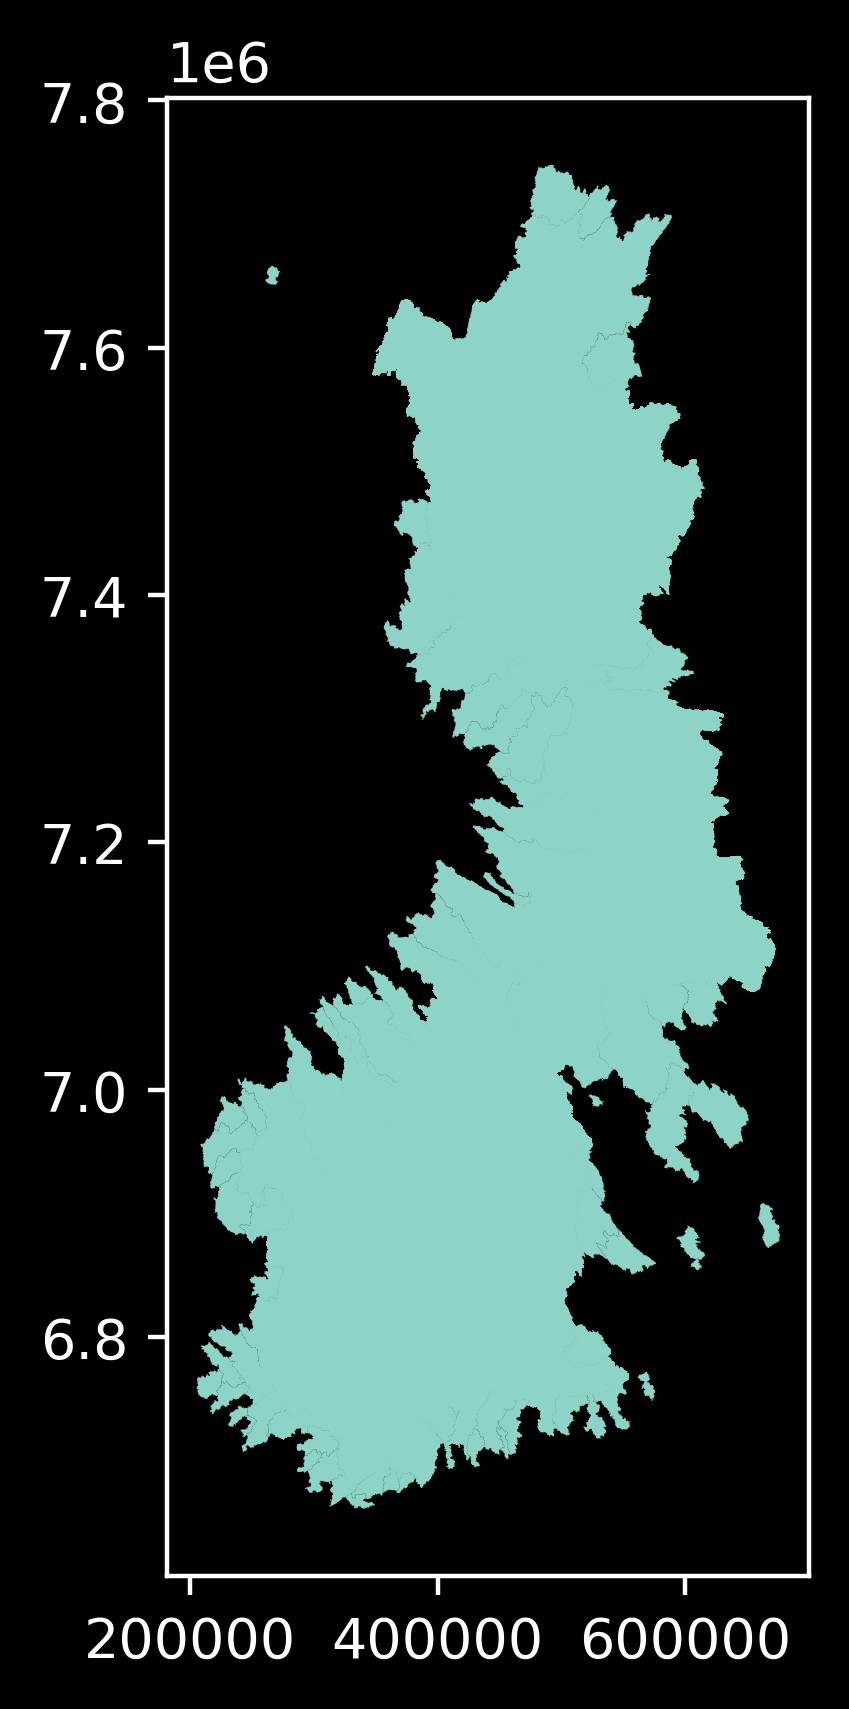

In [6]:
ax = watersheds.plot()

In [7]:
test_selection = 1

pbar = tqdm(watersheds.iterrows(), total=len(watersheds))

for i, watershed in pbar:
    #if i < test_selection:
        #continue

    pbar.set_description(f"Processing catchment {i}")
    # Changing to GeoDataFrame
    watershed = geopd.GeoDataFrame(
                    dict(zip(list(watershed.index), list(watershed.values))),
                    crs=watersheds.crs, geometry='geometry', index=[0])
    
    minx = watershed.bounds.at[0, 'minx']
    miny = watershed.bounds.at[0, 'miny']
    maxx = watershed.bounds.at[0, 'maxx']
    maxy = watershed.bounds.at[0, 'maxy']

    """
    Land cover
    """
    #pbar.set_description(f"Doing land cover for catchment {i}")
    year_values = []
    counter = 0
    for lc_year in land_cover_paths:
        land_cover_path = land_cover_paths[lc_year]
        watershed = add_lc_to_watersheds(watershed, land_cover_path, lc_classes, lc_year)
        # the end result shouldnt have multiple columns with same name and values
        #if counter > 0:
            #watershed_lc.drop(['geometry', 'area', 'Paikka_Id'], axis=1)
        #year_values.append(watershed_lc)
        counter += 1
    #watershed = pd.concat(year_values, axis=1)
    
    watersheds.loc[i, lc_columns] = watershed.loc[0, lc_columns]

    """
    Soil
    """
    #pbar.set_description(f"Doing soil class for catchment {i}")
    
    soil = geopd.read_file(soil_path, bbox=(minx, miny, maxx, maxy))
    soil = soil.clip(watershed, keep_geom_type=True)

    # There is soil data
    if len(soil) > 0:
        for soil_class in soil_classes:
            # Classifying into given classes
            soil.loc[soil["PINTAMAALAJI_KOODI"].isin(soil_classes[soil_class]), "soil_class"] = soil_class
            
        soil = soil.dissolve(by="soil_class", as_index=False)
        watershed_area = watershed.area.sum()
            
        for soil_class in soil_classes:
            soil_class_area = soil[soil["soil_class"] == soil_class].area.sum()
            # multiplying by 100 to get percentage
            watersheds.at[i, f"{soil_class}_perc"] = round((soil_class_area / watershed_area) * 100, 4)

    # Handling nodata situation
    else:
        for soil_class in soil_classes:
            watersheds.at[i, f"{soil_class}_perc"] = 0
    """
    Soil depth
    """
    #pbar.set_description(f"Doing soil depth for catchment {i}")

    # Opening window of the data from the area of the watershed    
    with rasterio.open(soil_depth_path) as src:
        profile = src.profile
        values = src.read(
            1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
            boundless=True, fill_value=profile['nodata'])
    
    profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
    profile['width'] = values.shape[1]
    profile['height'] = values.shape[0]

    # The typical, non empty case
    if profile['width'] and profile['height'] > 0:
    
        # Nodata and waters are excluded so that they don't interfere
        masked_values = ma.masked_values(values, profile['nodata'])
        # Waters are represented as -99 and are removed
        masked_values = ma.masked_values(masked_values, -99)
        
        area_mask = rasterize(
                    watershed['geometry'], (profile['height'], profile['width']),
                    dtype=profile['dtype'], transform=profile['transform'], all_touched=True)
    
        # When calculating the average, unwanted regions must be masked
        clipped_values = ma.masked_where(area_mask == 0, masked_values)
        
        # If the area is completely covered by lakes, the value is set to 0
        warnings.filterwarnings("error") 
        try:
            average_depth = round(clipped_values.sum() / clipped_values.count(), 4)
    
        except:
            average_depth = 0
            print(f"soil depth was set to zero for watershed {i}, because there were no non-masked values")
        warnings.filterwarnings("default") 
    
        watersheds.at[i, f"soil_depth"] = average_depth
    # Handling the empty exception
    else:
        print(f"soil depth was set to zero for watershed {i}, because there were no non-masked values")
        watersheds.at[i, f"soil_depth"] = 0

    """
    Slope
    """
    #pbar.set_description(f"Doing slope for catchment {i}")

    with rasterio.open(slope_path) as src:
            profile = src.profile
            values = src.read(
                1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
                boundless=True, fill_value=profile['nodata'])
        
    profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
    profile['width'] = values.shape[1]
    profile['height'] = values.shape[0]

    # Nodata and waters are excluded so that they don't interfere
    masked_values = ma.masked_values(values, profile['nodata'])

    
    area_mask = rasterize(
            watershed['geometry'], (profile['height'], profile['width']),
            dtype=profile['dtype'], transform=profile['transform'], all_touched=True)

    # When calculating the average, unwanted regions must be masked
    clipped_values = ma.masked_where(area_mask == 0, masked_values)
    
    # If the area is completely covered by lakes, the value is set to 0
    warnings.filterwarnings("error") 
    try:
        average = round(clipped_values.sum() / clipped_values.count(), 4)

    except:
        average = 0
        print(f"slope was set to zero for watershed {i}, because there were no values")

    warnings.filterwarnings("default") 
    watersheds.at[i, f"slope"] = average

    """
    Elevation
    """
    # Opening window of the data from the area of the watershed    
    with rasterio.open(dem_path) as src:
        profile = src.profile
        values = src.read(
            1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
            boundless=True, fill_value=profile['nodata'])
    
    profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
    profile['width'] = values.shape[1]
    profile['height'] = values.shape[0]

    # Nodata and waters are excluded so that they don't interfere
    masked_values = ma.masked_values(values, profile['nodata'])

    
    area_mask = rasterize(
            watershed['geometry'], (profile['height'], profile['width']),
            dtype=profile['dtype'], transform=profile['transform'], all_touched=True)

    # When calculating the average, unwanted regions must be masked
    clipped_values = ma.masked_where(area_mask == 0, masked_values)

    

    """
    Calculating elevation descriptors
    """
    
    # Mean
    watersheds.at[i, 'elev_mean'] = np.nanmean(clipped_values)
    # Minimum
    watersheds.at[i, 'elev_min'] = clipped_values.min()

    # 10th percentile
    watersheds.at[i, 'elev_10'] = np.nanpercentile(clipped_values, 10)
    # median
    watersheds.at[i, 'elev_50'] = np.nanpercentile(clipped_values, 50)
    # 90 th percentile
    subwatersheds.at[i, 'elev_90'] = np.nanpercentile(clipped_values, 90)
    
    watersheds.at[i, 'elev_max'] = clipped_values.max()
    
    #if i == test_selection:
        #break
watersheds['elev_range'] =  watersheds['elev_max'] - watersheds['elev_min']
watersheds.to_file(dst_path, layer="v1", driver="GPKG")

  0%|          | 0/320 [00:00<?, ?it/s]

In [8]:
watersheds

,Paikka_Id,area,geometry,crop_perc_2000,grass_perc_2000,shrubs_perc_2000,dwood_perc_2000,ewood_perc_2000,urban_perc_2000,inwater_perc_2000,...,glaciofluvial_perc,silt_perc,till_perc,clay_perc,peat_perc,soil_depth,slope,elev_min,elev_max,elev_range
0,996,3.079473e+09,"POLYGON ((381210 7007980, 381210 7007970, 3811...",6.654220,0.091192,17.140426,3.592700,54.970782,2.726711,8.899365,...,3.2544,5.0789,50.2977,0.0595,25.1479,10.9001,2.3149,107.508003,269.454987,161.946991
1,1003,2.158788e+09,"POLYGON ((461570 7052380, 461570 7052370, 4615...",5.897477,0.102858,15.528577,6.394733,49.800852,2.309118,17.425138,...,3.1452,2.0539,46.1200,0.3921,21.6176,9.5547,1.8085,101.355003,239.233994,137.878998
2,1008,5.763810e+09,"POLYGON ((461570 7052380, 461570 7052370, 4615...",5.602596,0.095476,14.940969,6.364929,47.588412,2.931040,20.514123,...,3.5319,2.1297,45.6779,0.3222,15.7472,9.8980,2.3433,94.766998,239.233994,144.466995
3,1009,5.966547e+09,"POLYGON ((461570 7052380, 461570 7052370, 4615...",5.718778,0.096047,15.010927,6.392424,47.726280,2.959742,20.181268,...,3.4942,2.1851,46.2792,0.3113,15.5247,9.8728,2.3697,90.000000,239.233994,149.233994
4,1012,6.883996e+09,"POLYGON ((461570 7052380, 461570 7052370, 4615...",6.096145,0.111552,15.140834,6.393620,47.528304,3.083913,19.803403,...,3.3936,2.3576,48.0902,0.3270,14.6877,9.8848,2.4046,86.246002,239.233994,152.987991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,961,2.072101e+09,"POLYGON ((589840 7022170, 589840 7022140, 5898...",3.144400,0.122794,15.951874,5.011132,49.352108,2.716558,21.532180,...,4.3685,0.8833,41.9901,0.1441,11.3135,11.2434,3.4011,95.541000,295.407013,199.866013
316,964,4.485919e+08,"POLYGON ((518500 6957260, 518500 6957250, 5184...",2.416908,0.037743,13.189718,5.211241,53.593633,2.490319,21.615438,...,1.3021,0.1756,36.7714,0.0185,10.5958,8.0723,3.4081,94.288002,210.623993,116.335991
317,1369,2.014959e+08,"POLYGON ((494629.907 7381100.953, 494629.907 7...",0.013861,0.053905,22.110785,1.200997,56.893487,0.334825,10.182136,...,0.4834,0.0000,69.8703,0.0000,14.0708,10.9167,2.9365,145.302002,361.101013,215.799011
318,1366,3.985687e+08,"POLYGON ((488999.91 7357010.684, 488999.91 735...",1.513626,0.157221,24.879786,4.955514,50.029138,0.761176,7.553329,...,1.8165,0.0248,70.2968,0.0000,17.4564,9.9107,2.3100,124.541000,362.648987,238.107986
